# Прогноз температуры сплава для металлургического комбината «Стальная птица»

Металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали и хочет контролировать температуру сплава.

**Описание технологического процесса:**
1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
2. Из сплава выводится сера (процесс десульфурации), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют (изменяют ее состав), подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.
3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят ее химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
4. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

**Цель бизнеса:** оптимизация производственных расходов

**Цель исследования:** построение модели для предсказания температуры сплава

**Ход исследования**

Данные для исследования будут получены из семи файлов. О качестве данных ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Необходимо будет проверить данные на ошибки и оценить их влияние на исследование. На этапе предобработки нужно осуществить поиск возможностей исправления всех ошибок данных, которые не приведут к искажению конечного результата. При необходимости, осуществим создание новых столбцов.

**Этапы исследования:**
1. Загрузка и обзор данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединенного датафрейма
5. Подготовка данных для обучения моделей
6. Обучение моделей машинного обучения
7. Выбор лучшей модели машинного обучения
8. Написание общего вывода

## Загрузка и обзор данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import sklearn
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import f1_score
#from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from catboost import CatBoostClassifier

Определим переменные:

In [2]:
RANDOM_STATE = 190525
TEST_SIZE = 0.25

Откроем файлы с датасетами:

In [3]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

Выведем первые строки датафрейма `data_arc_new`:

In [4]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Датафрейм содержит данные об электродах:
* `key` - номер партии
* `Начало нагрева дугой` - время начала нагрева
* `Конец нагрева дугой` - время окончания нагрева
* `Активная мощность` - значение активной мощности
* `Реактивная мощность` - значение реактивной мощности

In [5]:
try:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

Выведем первые строки датафрейма `data_bulk_new`:

In [6]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Датафрейм содержит данные о подаче сыпучих материалов (объем):
* `key` - номер партии
* `Bulk 1` … `Bulk 15` - объем подаваемого материала

In [7]:
try:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

Выведем первые строки датафрейма `data_bulk_time_new`:

In [8]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Датафрейм содержит данные о подаче сыпучих материалов (время):
* `key` - номер партии
* `Bulk 1` … `Bulk 15` - время подачи материала

In [9]:
try:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

Выведем первые строки датафрейма `data_gas_new`:

In [10]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Датафрейм содержит данные о продувке сплава газом:
* `key` - номер партии
* `Газ 1` - объем подаваемого газа

In [11]:
try:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

Выведем первые строки датафрейма `data_temp_new`:

In [12]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Датафрейм содержит результаты измерения температуры:
* `key` - номер партии
* `Время замера` - время замера
* `Температура` - значение температуры

In [13]:
try:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

Выведем первые строки датафрейма `data_wire_new`:

In [14]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датафрейм содержит данные о проволочных материалах (объем):
* `key` - номер партии
* `Wire 1` … `Wire 9` - объем подаваемых проволочных материалов

In [15]:
try:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

Выведем первые строки датафрейма `data_wire_time_new`:

In [16]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датафрейм содержит данные о проволочных материалах (время):
* `key` - номер партии
* `Wire 1` … `Wire 9` - время подачи проволочных материалов

Во всех файлах столбец `key` содержит номер партии. В файлах несколькими строками с одинаковым значением `key` обозначаются разные итерации обработки.

In [17]:
len(data_arc_new['key'].unique())

3214

In [18]:
len(data_bulk_new['key'].unique())

3129

In [19]:
len(data_gas_new['key'].unique())

3239

In [20]:
len(data_temp_new['key'].unique())

3216

In [21]:
len(data_wire_new['key'].unique())

3081

## Исследовательский анализ и предобработка данных

Проведем исследовательский анализ каждого датафрейма и при необходимости выполним предобработку данных. Работа будет заключаться в следующем:
* Переименование столбцов
* Отображение общей информации о данных
* Графическое представление данных
* Проверка данных на аномалии
* Корректировка типов данных
* Заполнение пропусков
* Удаление дубликатов

Определим функцию для отображения информации о датафрейме:

In [22]:
def get_info(df):
    print(df.info())
    print(100 * '-')
    display(df.describe().T)

Для отображения количественных признаков из датафрейма в виде гистограмм и диаграмм размаха ("ящик с усами") определим функцию:

In [23]:
def show_graph(data, column, hist_title, box_title, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    histplot = sns.histplot(
        data=data,
        x=column,
        bins=100,
        color='darkcyan',
        kde=True,
        ax=axes[0]
    )
    histplot.set(
        title=hist_title,
        xlabel=xlabel,
        ylabel='Количество'
    )
    histplot.axvline(data[column].median(), c='r')
    boxplot = sns.boxplot(
        data=data,
        x=column,
        color='salmon',
        ax=axes[1]
    )
    boxplot.set(
        title=box_title,
        xlabel=xlabel
    )

### Датафрейм `data_arc_new`

Произведем переименование столбцов:

In [24]:
data_arc_new.columns = [
    'key',
    'heating_start',
    'heating_end',
    'active_power',
    'reactive_power'
]

Выведем общую информацию о датафрейме `data_arc_new`:

In [25]:
get_info(data_arc_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   heating_start   14876 non-null  object 
 2   heating_end     14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
active_power,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
reactive_power,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


Пропусков в данных нет. Данные в столбцах `arc_heating_start` и `arc_heating_end` необходимо привести к типу `datetime`:

In [26]:
data_arc_new['heating_start'] = pd.to_datetime(data_arc_new['heating_start'])
data_arc_new['heating_end'] = pd.to_datetime(data_arc_new['heating_end'])

Проверим типы данных:

In [27]:
data_arc_new.dtypes

key                        int64
heating_start     datetime64[ns]
heating_end       datetime64[ns]
active_power             float64
reactive_power           float64
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [28]:
data_arc_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим, за какой промежуток времени представлены данные в датафрейме:

In [29]:
print(data_arc_new['heating_start'].max() - data_arc_new['heating_start'].min())

126 days 06:22:40


In [30]:
print(data_arc_new['heating_end'].max() - data_arc_new['heating_end'].min())

126 days 06:20:13


Данные представлены на 126 дней (примерно 4 месяца).

Отобразим гистограмму и "ящик с усами" для столбца `active_power`:

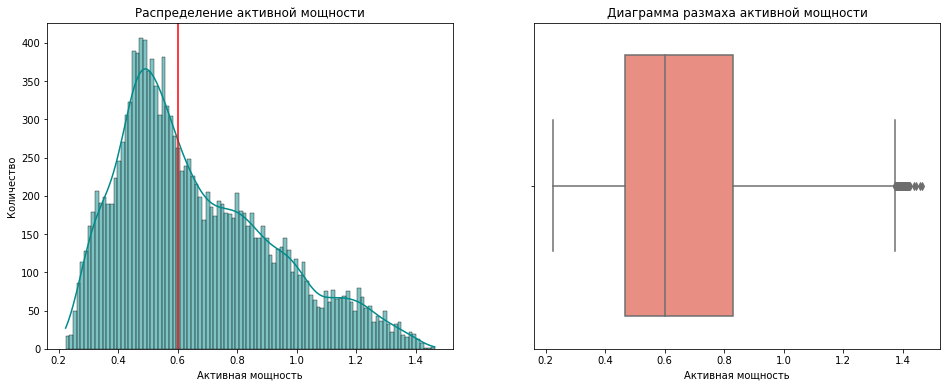

In [31]:
show_graph(
    data_arc_new,
    'active_power',
    'Распределение активной мощности',
    'Диаграмма размаха активной мощности',
    'Активная мощность'
)

Распределение активной мощности напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на активную мощность около 0.6, т.е. большинство электродов работают на этой мощности. Явных аномалий в данных не отмечено.

Отобразим гистограмму и "ящик с усами" для столбца `reactive_power`:

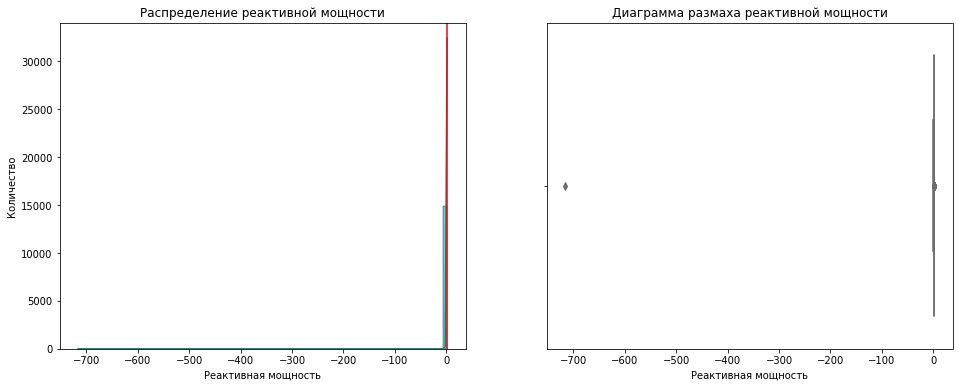

In [32]:
show_graph(
    data_arc_new,
    'reactive_power',
    'Распределение реактивной мощности',
    'Диаграмма размаха реактивной мощности',
    'Реактивная мощность'
)

Из-за отрицательных аномалий график не дает понять природу распределения данных. Выявим данные аномалии:

In [33]:
data_arc_new[data_arc_new['reactive_power'] < 0]

,key,heating_start,heating_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Выявлено одно отрицательное значение реактивной мощности -715 ед. Данную аномалию можно удалить из датафрейма без потери качества в данных:

In [34]:
data_arc_new = data_arc_new[data_arc_new['reactive_power'] > 0]

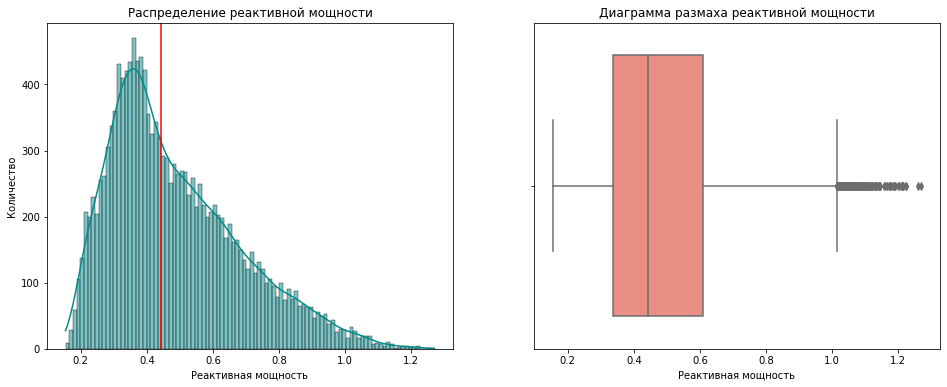

In [35]:
show_graph(
    data_arc_new,
    'reactive_power',
    'Распределение реактивной мощности',
    'Диаграмма размаха реактивной мощности',
    'Реактивная мощность'
)

Распределение реактивной мощности похоже на распределение активной мощности - напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на реактивную мощность около 0.44, т.е. большинство электродов работают на этой мощности. Явных аномалий в данных не отмечено.

Добавим новый столбец с данными, которые могут быть использованы в модели машинного обучения - длительность нагрева и количество итераций нагрева:

In [36]:
data_arc_new['heating_duration'] = (data_arc_new['heating_end'] - data_arc_new['heating_start']).dt.total_seconds()
data_arc_new = data_arc_new.merge(
    data_arc_new.pivot_table(
        index='key',
        values='active_power',
        aggfunc='count'
    ).reset_index().rename(
        columns={
            'active_power': 'heating_iteration'
        }
    ),
    on='key',
    how='left'
)

Отобразим гистограмму и "ящик с усами" для столбца `heating_duration`:

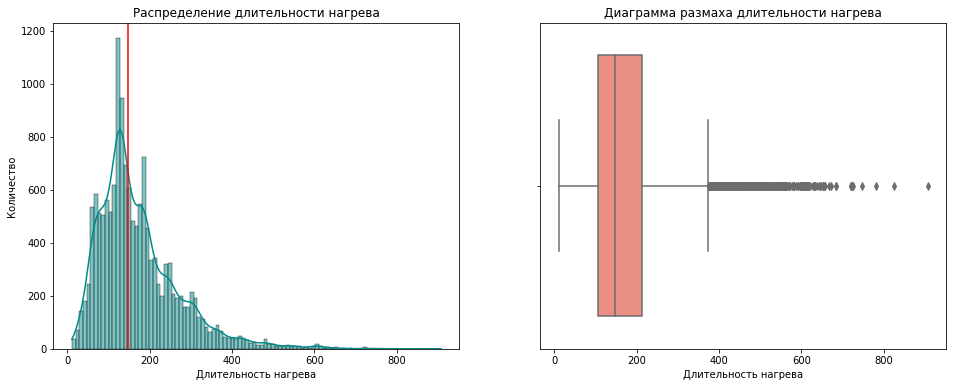

In [37]:
show_graph(
    data_arc_new,
    'heating_duration',
    'Распределение длительности нагрева',
    'Диаграмма размаха длительности нагрева',
    'Длительность нагрева'
)

Так же как и два предыдущие показателя, распределение длительности нагрева напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на длительность нагрева около 147, т.е. большинство электродов работают около 2.5 минут. Удалим из датафрейма данные с явными аномалиями в правом хвосте:

In [38]:
#percentage = len(data_arc_new[data_arc_new['Длительность нагрева'] >= 700]) / len(data_arc_new)
#print(f'Доля строк с аномалиями - {percentage:.2%}')
#data_arc_new = data_arc_new[data_arc_new['Длительность нагрева'] < 700]

Отобразим гистограмму и "ящик с усами" для столбца `heating_iteration`:

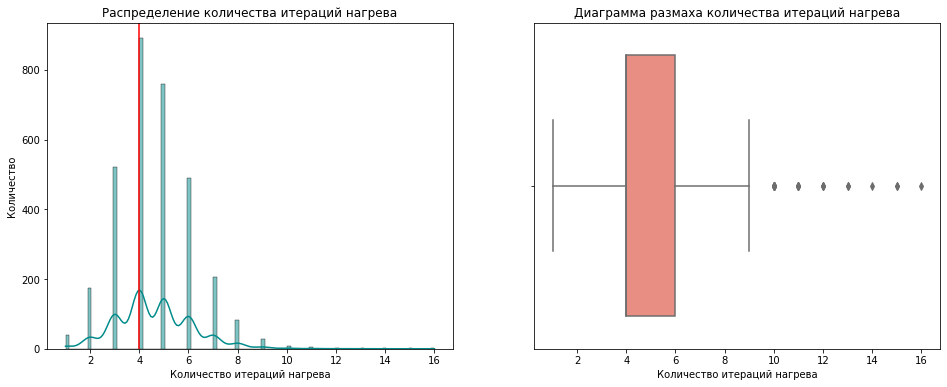

In [39]:
show_graph(
    data_arc_new.drop_duplicates(subset='key', keep='first'),
    'heating_iteration',
    'Распределение количества итераций нагрева',
    'Диаграмма размаха количества итераций нагрева',
    'Количество итераций нагрева'
)

Распределение количества итераций нагрева напоминает нормальное распределение, наибольшее количество значений приходится на количество итераций, равное 4.

Сформируем итоговый датафрейм `data_arc_new_final`:

In [40]:
data_arc_new_final = data_arc_new.groupby('key').agg(
    min_active_power = ('active_power', 'min'),
    max_active_power = ('active_power', 'max'),
    mean_active_power = ('active_power', 'mean'),
    min_reactive_power = ('reactive_power', 'min'),
    max_reactive_power = ('reactive_power', 'max'),
    mean_reactive_power = ('reactive_power', 'mean'),
    min_heating_duration = ('heating_duration', 'min'),
    max_heating_duration = ('heating_duration', 'max'),
    mean_heating_duration = ('heating_duration', 'mean'),
    heating_iteration = ('heating_iteration', 'mean')
).reset_index()

data_arc_new_final.head()

,key,min_active_power,max_active_power,mean_active_power,min_reactive_power,max_reactive_power,mean_reactive_power,min_heating_duration,max_heating_duration,mean_heating_duration,heating_iteration
0,1,0.305130,0.867133,0.607346,0.211253,0.643691,0.428564,148.0,365.0,219.60,5
1,2,0.261665,0.786322,0.534852,0.205527,0.542517,0.363339,126.0,338.0,202.75,4
2,3,0.421693,1.222963,0.812728,0.272562,0.863676,0.587491,65.0,280.0,131.00,5
3,4,0.310693,0.887855,0.676622,0.241781,0.654661,0.514248,99.0,278.0,185.25,4
4,5,0.324563,0.892957,0.563238,0.279102,0.660807,0.421998,71.0,415.0,217.25,4


### Датафрейм `data_bulk_new`

Произведем переименование столбцов:

In [41]:
data_bulk_new.columns = ['key'] + [f'bulk_{i}' for i in range(1, 16)]

Выведем общую информацию о датафрейме `data_bulk_new`:

In [42]:
get_info(data_bulk_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
bulk_1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Типы данных в норме, но датафрейм в каждом столбце имеет пропуски в данных - возможно, этот факт связан с технологическим процессом, когда каждой партии подается определенное количество материала или не подается вовсе. Получается, что пропуски данных означают, что тот или иной сыпучий материал 1-15 не использовался в процессе производства той или иной партии. Определим долю пропусков каждого сыпучего материала:

In [43]:
pd.DataFrame(
    {
        'Доля пропусков': pd.Series(data_bulk_new.drop('key', axis=1).isna().sum() / data_bulk_new.shape[0] * 100)
    }
).sort_values(by='Доля пропусков', ascending=False)

,Доля пропусков
bulk_8,99.968041
bulk_13,99.424736
bulk_9,99.392777
bulk_2,99.296900
bulk_7,99.201023
bulk_5,97.539150
bulk_10,94.375200
bulk_11,94.343241
bulk_1,91.946309
bulk_6,81.591563


Девять из пятнадцати признаков имеют более 90% пропусков, остальные признаки имеют также значительное количество пропусков. Минимальная доля пропущенных значений составила чуть больше 10%.

Отобразим редко использующиеся в производстве сыпущие материалы:

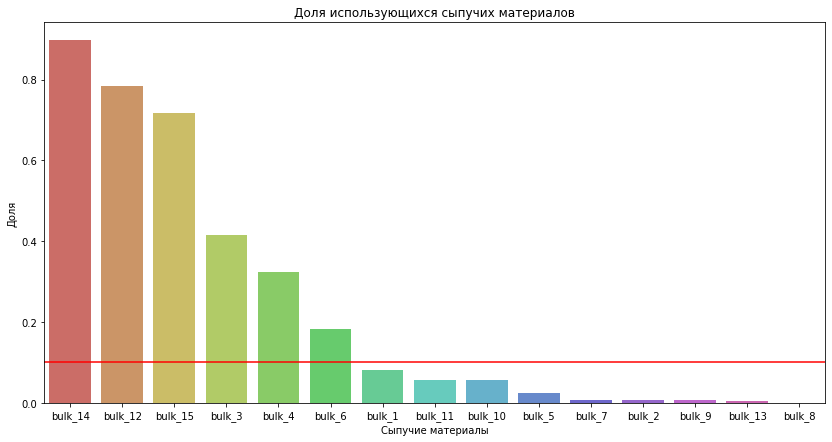

In [44]:
tmp_df = pd.DataFrame(
    {
        'Доля': (~data_bulk_new.drop('key', axis=1).isna()).mean().sort_values(ascending=False)
    }
)
tmp_df.reset_index(drop=False, inplace=True)
tmp_df.columns = ['bulk', 'prop']

plt.figure(figsize=(14, 7))
barplot = sns.barplot(
    data=tmp_df,
    x='bulk',
    y='prop',
    palette='hls'
)
barplot.axhline(0.1, c='r')

barplot.set(
    title='Доля использующихся сыпучих материалов',
    xlabel='Сыпучие материалы',
    ylabel='Доля'
);

Сыпучие материалы № 8, 13, 9, 2, 7, 5, 10, 11 и 1 используются при изготовлении менее 10% партий. В дальнейшем возможно не стоит эти данные добавлять в модель.

Далее проверим датафрейм на наличие явных дубликатов:

In [45]:
data_bulk_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим датафрейм на дубли партий:

In [46]:
data_bulk_new['key'].value_counts().max()

1

Максимальное значение сгруппированных партий равно единице, из этого можно сделать вывод о том, что в данном датафрейме партии уникальны в каждой строке.

Проверим, чтобы все партии имели хотя бы один сыпучий материал:

In [47]:
data_bulk_new.drop('key', axis=1).sum(axis=1).min()

19.0

Минимальный объем сыпучего материала равен 19, что говорит о том, что каждая партия имеет хотя бы один сыпучий материал.

Отобразим гистограмму и "ящик с усами" для всех признаков `bulk_1` … `bulk_15`:

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


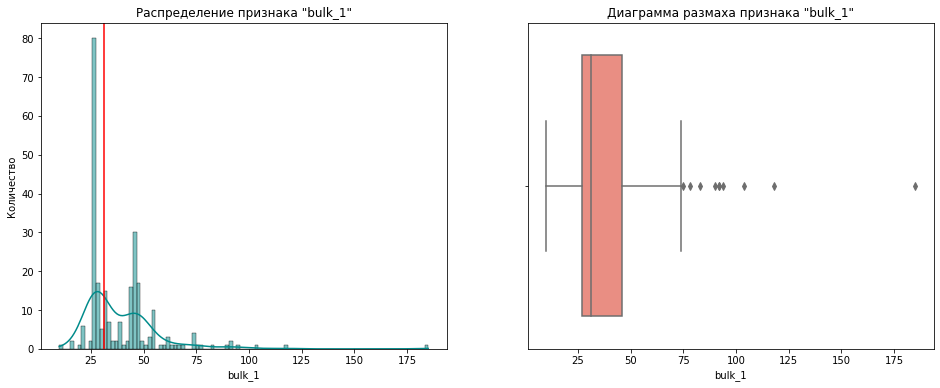

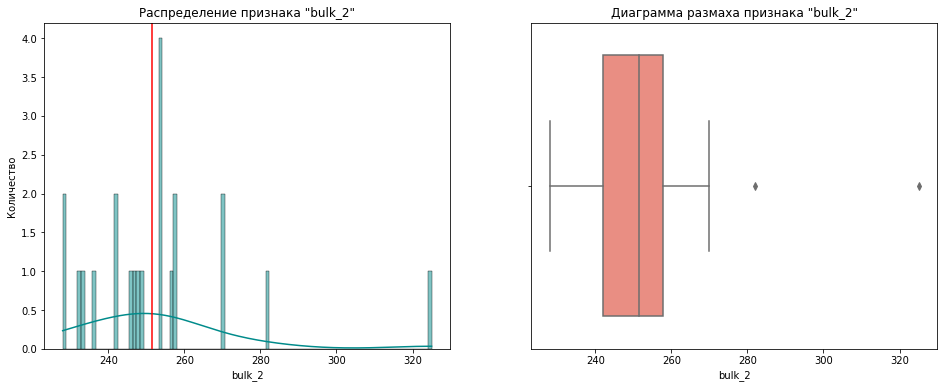

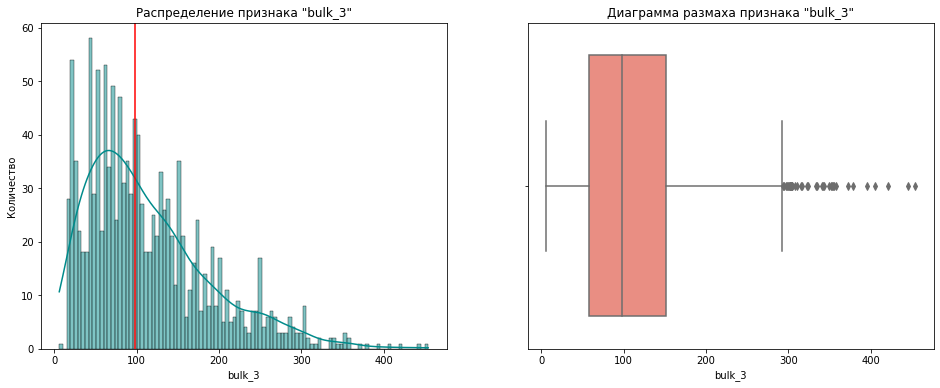

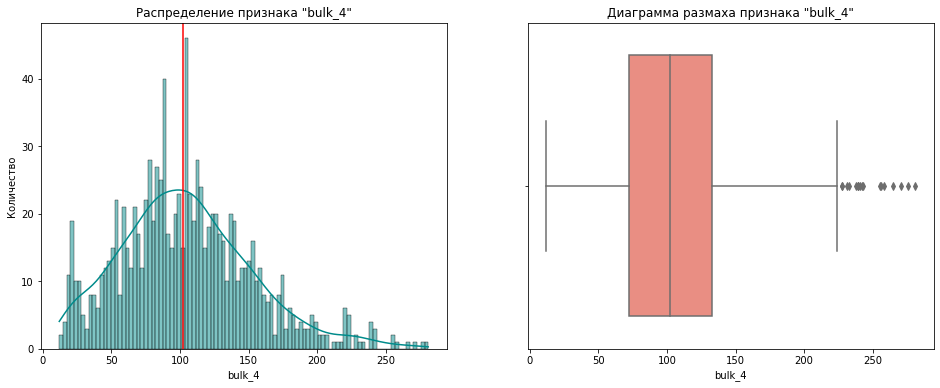

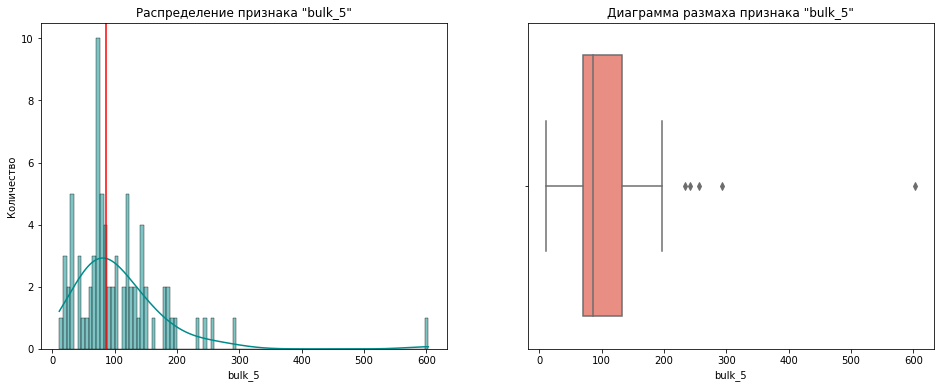

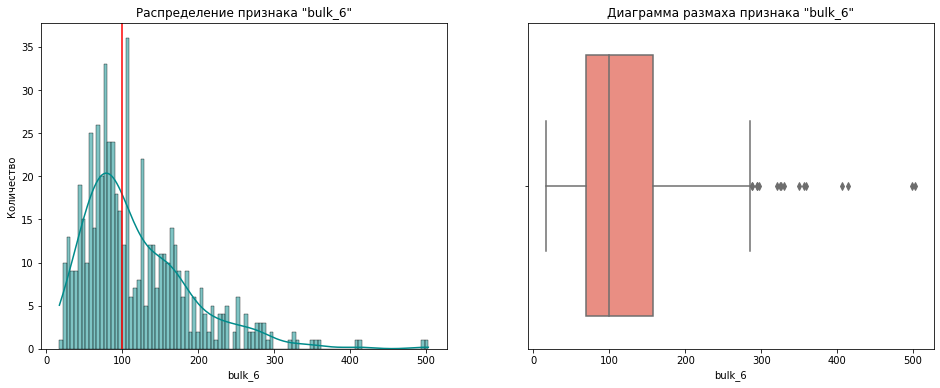

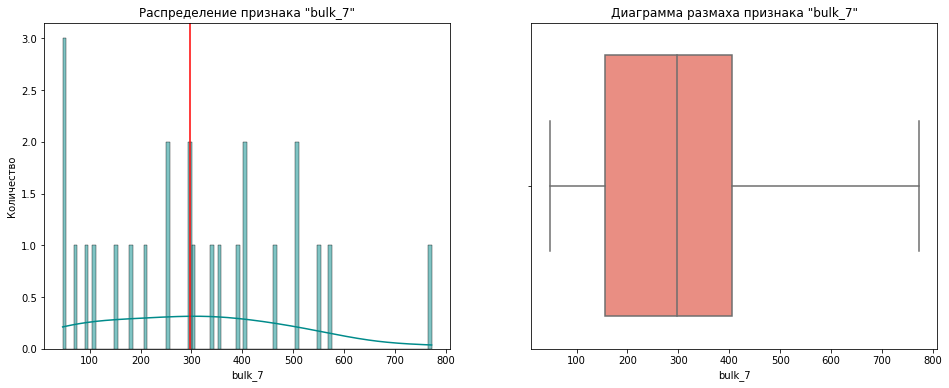

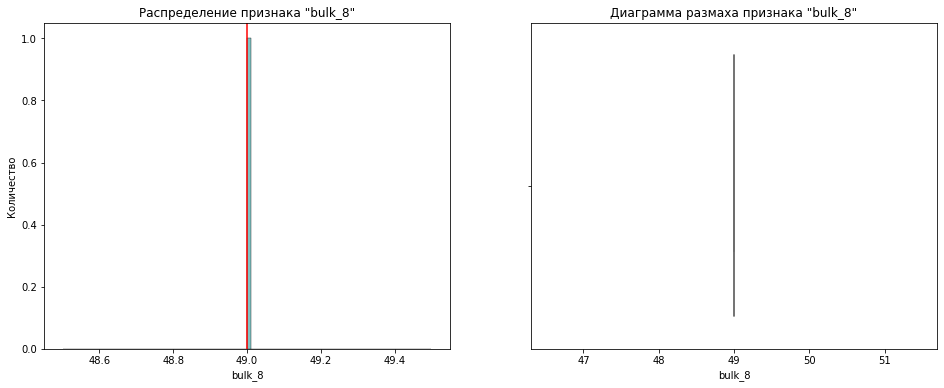

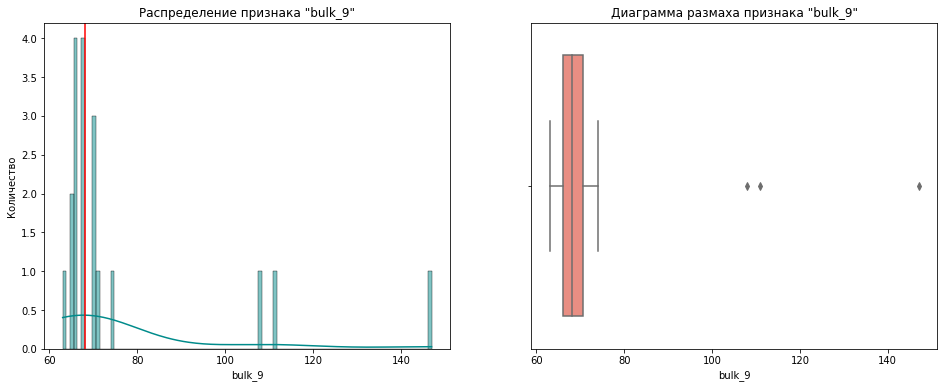

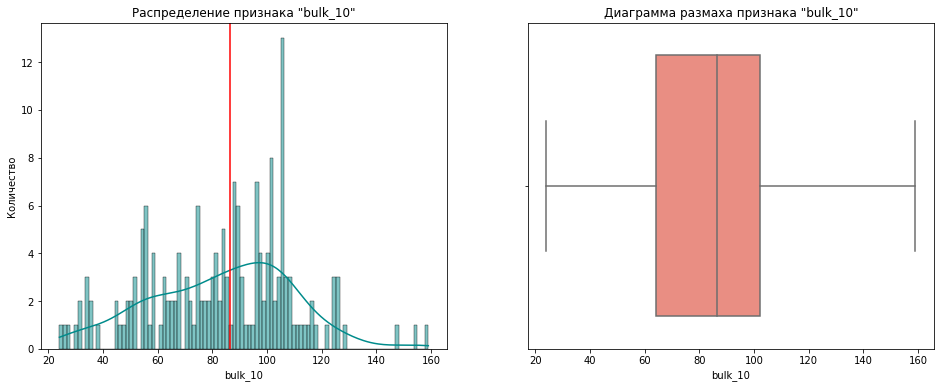

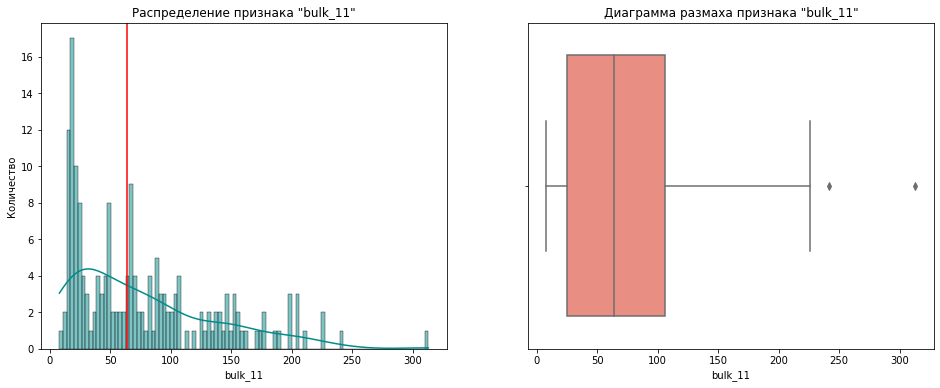

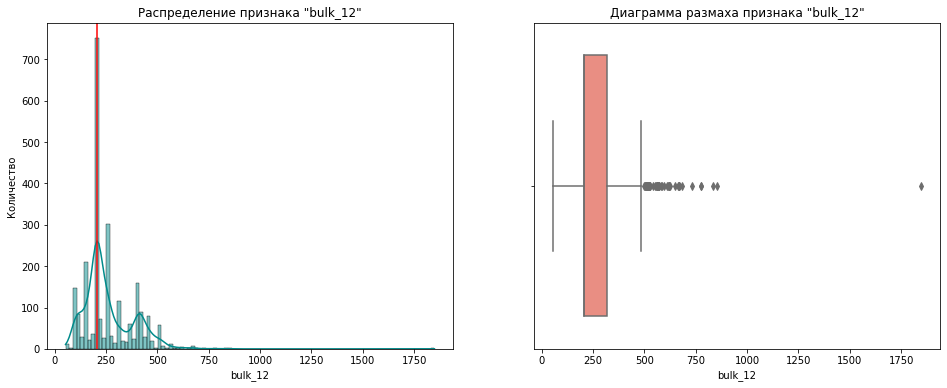

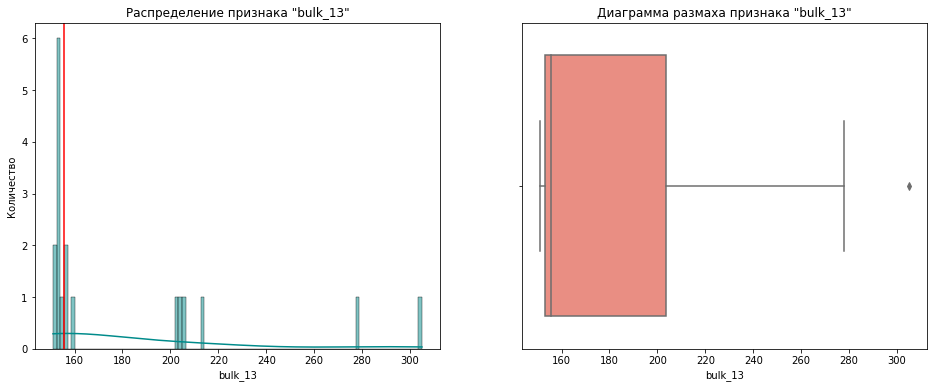

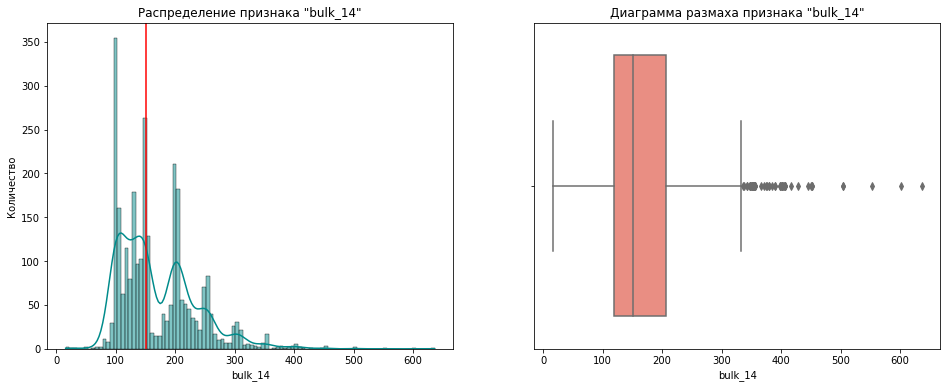

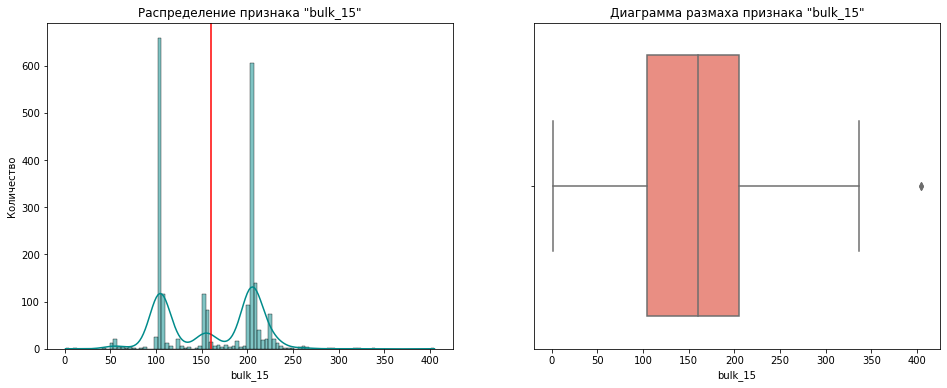

In [48]:
for i in data_bulk_new.drop('key', axis=1).columns:
    show_graph(
        data_bulk_new,
        i,
        f'Распределение признака "{i}"',
        f'Диаграмма размаха признака "{i}"',
        i
    )

Не все сыпучие материалы имеют нормальное распределение - для большинства характерны доминанты определенных значений с характерными пиками на графиках распределения. Графики распределений приближены к нормальному для сыпучих материалов № 3, 4 и 6. Обрабатывать выбросы в признаках не будем, т.к. они вполне могут соответствовать максимальным значениям.

Добавим в датафрейм суммарное значение сыпучих материалов:

In [49]:
data_bulk_new['bulk_total'] = data_bulk_new.drop('key', axis=1).sum(axis=1)

Сформируем итоговый датафрейм `data_bulk_new_final`:

In [50]:
data_bulk_new_final = data_bulk_new[
    ['key', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_total']
]#.fillna(0)

data_bulk_new_final.head()

,key,bulk_3,bulk_4,bulk_6,bulk_12,bulk_14,bulk_15,bulk_total
0,1,NaN,43.0,NaN,206.0,150.0,154.0,553.0
1,2,NaN,73.0,NaN,206.0,149.0,154.0,582.0
2,3,NaN,34.0,NaN,205.0,152.0,153.0,544.0
3,4,NaN,81.0,NaN,207.0,153.0,154.0,595.0
4,5,NaN,78.0,NaN,203.0,151.0,152.0,584.0


### Датафрейм `data_bulk_time_new`

Произведем переименование столбцов:

In [51]:
data_bulk_time_new.columns = ['key'] + [f'bulk_{i}' for i in range(1, 16)]

Выведем общую информацию о датафрейме `data_bulk_time_new`:

In [52]:
get_info(data_bulk_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


Очевидно, что структуры датафреймов `data_bulk_new` и `data_bulk_time_new` одинаковы: первый датафрейм отображает данные об объемах, второй - о времени подачи сыпучих материалов.

Приведем данные в столбцах `bulk_1` … `bulk_15` к типу `datetime`:

In [53]:
for i in data_bulk_time_new.drop('key', axis=1).columns:
    data_bulk_time_new[i] = pd.to_datetime(data_bulk_time_new[i])

Проверим типы данных:

In [54]:
data_bulk_time_new.dtypes

key                 int64
bulk_1     datetime64[ns]
bulk_2     datetime64[ns]
bulk_3     datetime64[ns]
bulk_4     datetime64[ns]
bulk_5     datetime64[ns]
bulk_6     datetime64[ns]
bulk_7     datetime64[ns]
bulk_8     datetime64[ns]
bulk_9     datetime64[ns]
bulk_10    datetime64[ns]
bulk_11    datetime64[ns]
bulk_12    datetime64[ns]
bulk_13    datetime64[ns]
bulk_14    datetime64[ns]
bulk_15    datetime64[ns]
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [55]:
data_bulk_time_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

На текущий момент видится нецелесообразным включение данных из датафрейма `data_bulk_time_new` в модель машиного обучения или даже формирование синтетического признака на его основе, т.к. не прослеживается четкой логической связи этих данных с целевым признаком.

### Датафрейм `data_gas_new`

Произведем переименование столбцов:

In [56]:
data_gas_new.columns = [
    'key',
    'gas'
]

Выведем общую информацию о датафрейме `data_gas_new`:

In [57]:
get_info(data_gas_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
gas,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


Пропусков в данных нет, также нет необходимости в преобразовании типов данных.

Далее проверим датафрейм на наличие явных дубликатов:

In [58]:
data_gas_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

Проверим датафрейм на дубли партий:

In [59]:
data_gas_new['key'].value_counts().max()

1

Максимальное значение сгруппированных партий равно единице, из этого можно сделать вывод о том, что в данном датафрейме партии уникальны в каждой строке.

Отобразим гистограмму и "ящик с усами" для столбца `Газ 1`:

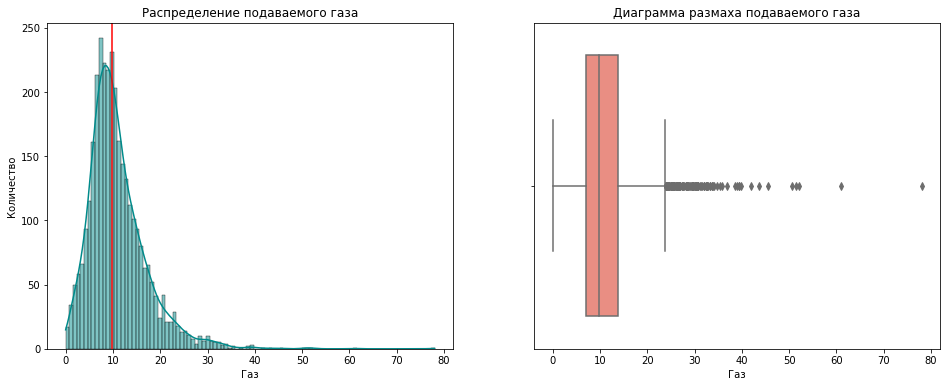

In [60]:
show_graph(
    data_gas_new,
    'gas',
    'Распределение подаваемого газа',
    'Диаграмма размаха подаваемого газа',
    'Газ'
)

Распределение данных о продувке сплава газом напоминает нормальное распределение с вытянутым правым хвостом. Наибольшее количество значений приходится на значение около 10. Удалим из датафрейма данные с явными аномалиями в правом хвосте:

In [61]:
#percentage = len(data_gas_new[data_gas_new['Газ 1'] >= 41]) / len(data_gas_new)
#print(f'Доля строк с аномалиями - {percentage:.2%}')
#data_gas_new = data_gas_new[data_gas_new['Газ 1'] < 41]

### Датафрейм `data_temp_new`

Произведем переименование столбцов:

In [62]:
data_temp_new.columns = [
    'key',
    'time',
    'temperature'
]

Выведем общую информацию о датафрейме `data_temp_new`:

In [63]:
get_info(data_temp_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          18092 non-null  int64  
 1   time         18092 non-null  object 
 2   temperature  14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
temperature,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


Данные в столбце `Время замера` необходимо привести к типу `datetime`:

In [64]:
data_temp_new['time'] = pd.to_datetime(data_temp_new['time'])

Проверим типы данных:

In [65]:
data_temp_new.dtypes

key                     int64
time           datetime64[ns]
temperature           float64
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [66]:
data_temp_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим, за какой промежуток времени представлены данные в датафрейме:

In [67]:
print(data_temp_new['time'].max() - data_temp_new['time'].min())

126 days 06:28:01


Данные представлены на 126 дней (примерно 4 месяца), что соотносится с периодом данных в датафрейме `data_arc_new`.

Отобразим гистограмму и "ящик с усами" для столбца `temperature`:

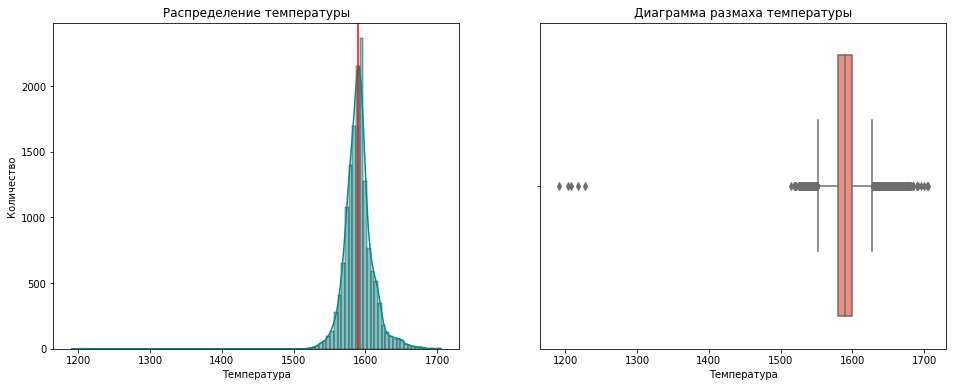

In [68]:
show_graph(
    data_temp_new,
    'temperature',
    'Распределение температуры',
    'Диаграмма размаха температуры',
    'Температура'
)

Распределение температуры напоминает нормальное распределение. Наибольшее количество значений приходится на температуру около 1600 градусов. Имеются явные аномалии, но их удалять нет смысла, т.к. в зависимости от типа стали и особенностей применяемой технологии температура плавления может достигать различных значений.

Определим долю пропусков в значениях температуры:

In [69]:
percentage = data_temp_new['temperature'].isna().sum() / len(data_temp_new)
print(f'Доля строк с пропусками - {percentage:.2%}')

Доля строк с пропусками - 18.94%


Доля строк с пропусками составила 19%, что достаточно существенно. Но т.к. в целевом признаке не должно быть пропусков данных, то такие строки надо удалить из датафрейма.

Сформируем итоговый датафрейм `data_temp_new_final`:

In [70]:
data_temp_new_final = data_temp_new.dropna().sort_values(by=['key', 'time']).groupby('key').agg(
    start_temperature = ('temperature', 'first'),
    end_temperature = ('temperature', 'last'),
    mean_temperature =('temperature', 'mean')
).reset_index()

data_temp_new_final.head()

,key,start_temperature,end_temperature,mean_temperature
0,1,1571.0,1613.0,1602.166667
1,2,1581.0,1602.0,1590.600000
2,3,1596.0,1599.0,1598.166667
3,4,1601.0,1625.0,1616.800000
4,5,1576.0,1602.0,1589.000000


### Датафрейм `data_wire_new`

Произведем переименование столбцов:

In [71]:
data_wire_new.columns = ['key'] + [f'wire_{i}' for i in range(1, 10)]

Выведем общую информацию о датафрейме `data_wire_new`:

In [72]:
get_info(data_wire_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
wire_1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
wire_2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
wire_3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
wire_4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
wire_5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
wire_6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
wire_7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
wire_8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
wire_9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Типы данных в норме, но датафрейм в каждом столбце имеет пропуски в данных - возможно, этот факт связан с технологическим процессом, когда каждой партии подается определенное количество материала или не подается вовсе. Получается, что пропуски данных означают, что тот или иной проволочный материал 1-9 не использовался в процессе производства той или иной партии. Определим долю пропусков каждого проволочного материала:

In [73]:
pd.DataFrame(
    {
        'Доля пропусков': pd.Series(data_wire_new.drop('key', axis=1).isna().sum() / data_wire_new.shape[0] * 100)
    }
).sort_values(by='Доля пропусков', ascending=False)

,Доля пропусков
wire_5,99.967543
wire_7,99.642973
wire_4,99.545602
wire_8,99.383317
wire_9,99.058747
wire_3,97.955209
wire_6,97.630639
wire_2,64.978903
wire_1,0.843882


Практически все признаки (семь из девяти) имеют более 90% пропусков. Минимальную доля пропущенных значений имеет признак №1.

Отобразим редко использующиеся в производстве проволочные материалы:

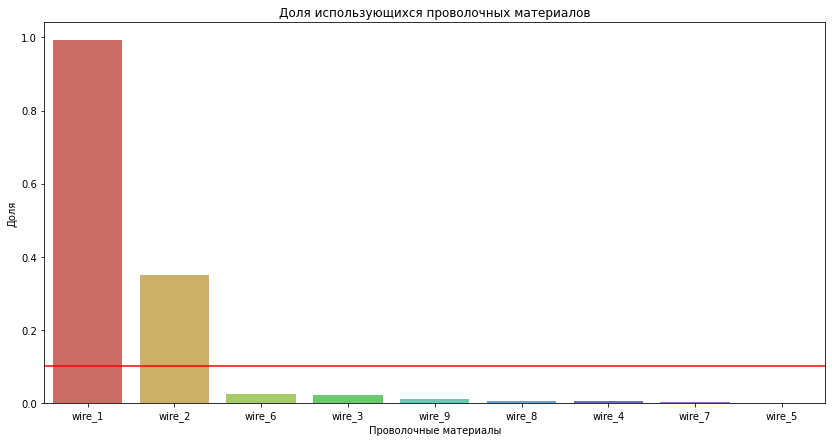

In [74]:
tmp_df = pd.DataFrame(
    {
        'prop': (~data_wire_new.drop('key', axis=1).isna()).mean().sort_values(ascending=False)
    }
)
tmp_df.reset_index(drop=False, inplace=True)
tmp_df.columns = ['wire', 'prop']

plt.figure(figsize=(14, 7))
barplot = sns.barplot(
    data=tmp_df,
    x='wire',
    y='prop',
    palette='hls'
)
barplot.axhline(0.1, c='r')

barplot.set(
    title='Доля использующихся проволочных материалов',
    xlabel='Проволочные материалы',
    ylabel='Доля'
);

Проволочные материалы № 5, 7, 4, 8, 9, 3 и 6 используются при изготовлении менее 10% партий. В дальнейшем возможно не стоит эти данные добавлять в модель.

Далее проверим датафрейм на наличие явных дубликатов:

In [75]:
data_wire_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено. Проверим датафрейм на дубли партий:

In [76]:
data_wire_new['key'].value_counts().max()

1

Максимальное значение сгруппированных партий равно единице, из этого можно сделать вывод о том, что в данном датафрейме партии уникальны в каждой строке.

Проверим, чтобы все партии имели хотя бы один сыпучий материал:

In [77]:
data_wire_new.drop('key', axis=1).sum(axis=1).min()

1.9188

Минимальный объем проволочного материала равен 1.9188, что говорит о том, что каждая партия имеет хотя бы один проволочный материал.

Отобразим гистограмму и "ящик с усами" для всех признаков `wire_1` … `wire_9`:

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


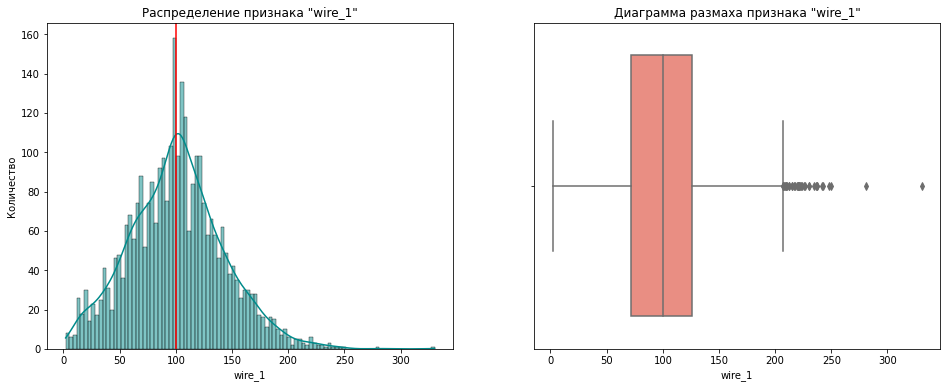

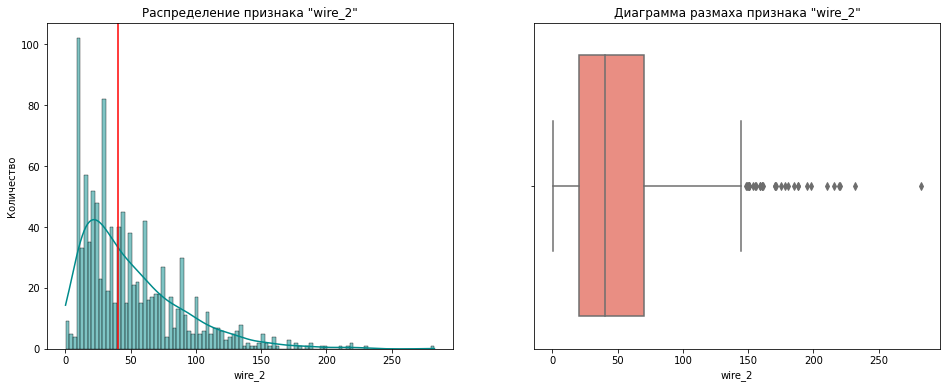

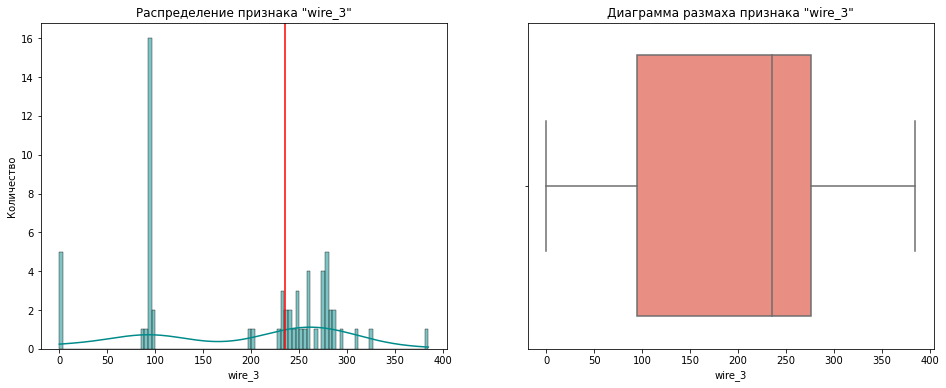

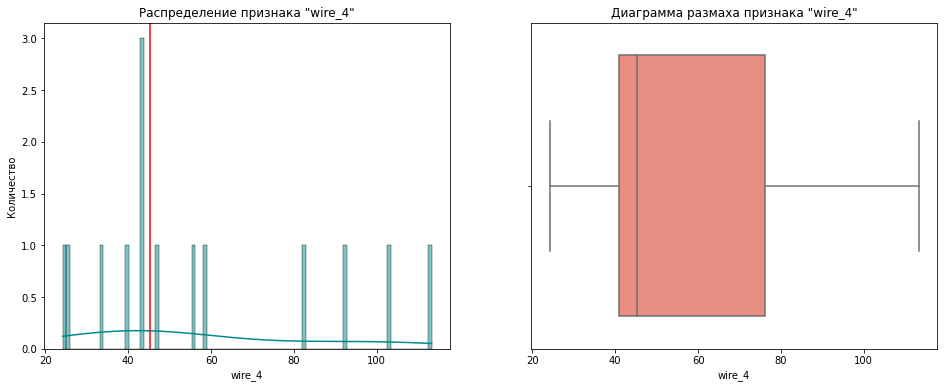

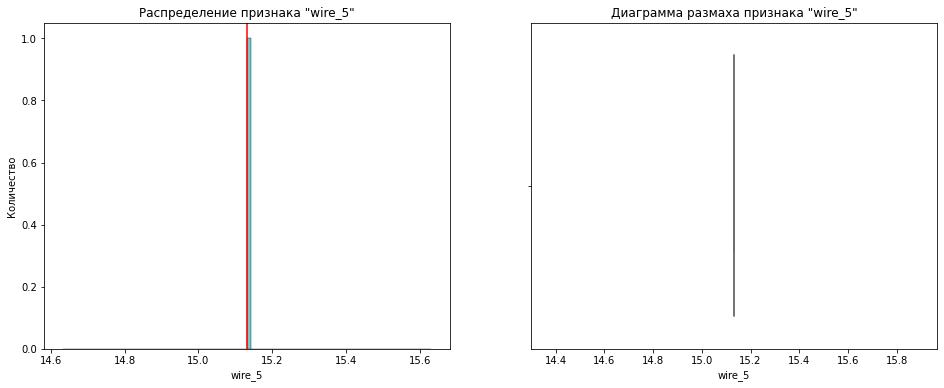

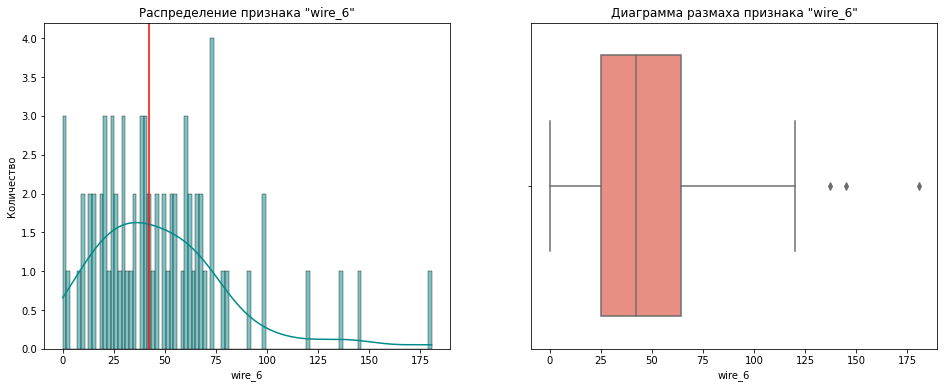

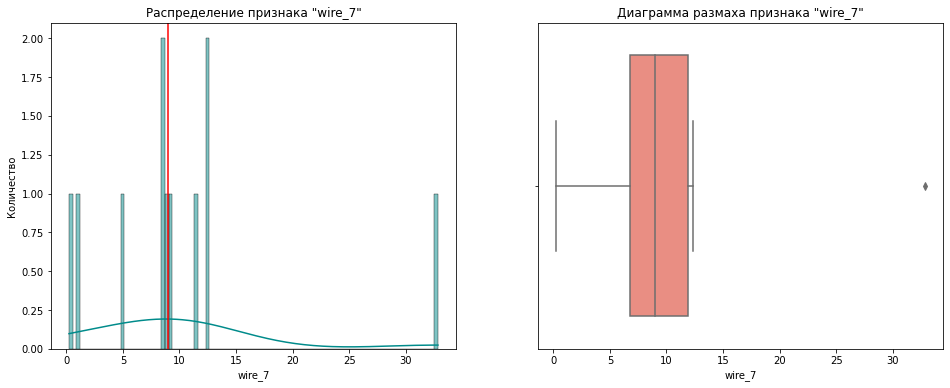

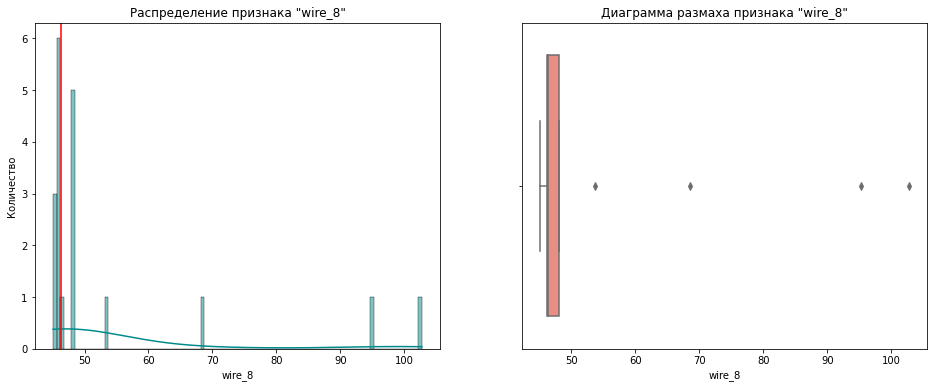

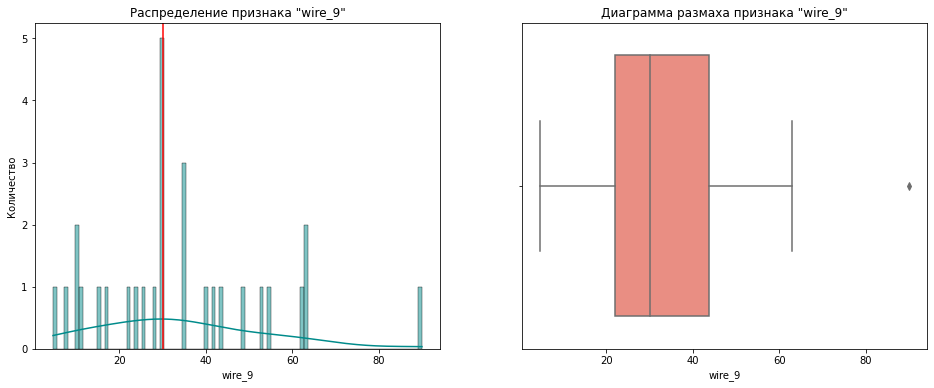

In [78]:
for i in data_wire_new.drop('key', axis=1).columns:
    show_graph(
        data_wire_new,
        i,
        f'Распределение признака "{i}"',
        f'Диаграмма размаха признака "{i}"',
        i
    )

Не все проволочные материалы имеют нормальное распределение - для большинства характерны доминанты определенных значений с характерными пиками на графиках распределения. Графики распределений приближены к нормальному для проволочных материалов № 1 и 2. Обрабатывать выбросы в признаках не будем, т.к. они вполне могут соответствовать максимальным значениям.

Добавим в датафрейм суммарное значение проволочных материалов:

In [79]:
data_wire_new['wire_total'] = data_wire_new.drop('key', axis=1).sum(axis=1)

Сформируем итоговый датафрейм `data_wire_new_final`:

In [80]:
data_wire_new_final = data_wire_new[
    ['key', 'wire_1', 'wire_2', 'wire_total']
]#.fillna(0)

data_wire_new_final.head()

,key,wire_1,wire_2,wire_total
0,1,60.059998,NaN,60.059998
1,2,96.052315,NaN,96.052315
2,3,91.160157,NaN,91.160157
3,4,89.063515,NaN,89.063515
4,5,89.238236,9.11456,98.352796


### Датафрейм `data_wire_time_new`

Произведем переименование столбцов:

In [81]:
data_wire_time_new.columns = ['key'] + [f'wire_{i}' for i in range(1, 10)]

Выведем общую информацию о датафрейме `data_wire_time_new`:

In [82]:
get_info(data_wire_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Очевидно, что структуры датафреймов `data_wire_new` и `data_wire_time_new` одинаковы: первый датафрейм отображает данные об объемах, второй - о времени подачи проволочных материалов.

Приведем данные в столбцах `wire_1` … `wire_9` к типу `datetime`:

In [83]:
for i in data_wire_time_new.drop('key', axis=1).columns:
    data_wire_time_new[i] = pd.to_datetime(data_wire_time_new[i])

Проверим типы данных:

In [84]:
data_wire_time_new.dtypes

key                int64
wire_1    datetime64[ns]
wire_2    datetime64[ns]
wire_3    datetime64[ns]
wire_4    datetime64[ns]
wire_5    datetime64[ns]
wire_6    datetime64[ns]
wire_7    datetime64[ns]
wire_8    datetime64[ns]
wire_9    datetime64[ns]
dtype: object

Далее проверим датафрейм на наличие явных дубликатов:

In [85]:
data_wire_time_new.duplicated().sum()

0

Явных дубликатов в датафрейме не обнаружено.

На текущий момент видится нецелесообразным включение данных из датафрейма `data_wire_time_new` в модель машиного обучения или даже формирование синтетического признака на его основе, т.к. не прослеживается четкой логической связи этих данных с целевым признаком.

## Объединение данных

Произведем объединение данных из датафреймов в один общий:

In [86]:
data = data_arc_new_final.merge(
    data_bulk_new_final,
    on='key',
    how='outer'
).merge(
    data_gas_new,
    on='key',
    how='outer'
).merge(
    data_temp_new_final,
    on='key',
    how='outer'
).merge(
    data_wire_new_final,
    on='key',
    how='outer'
)#.dropna()

In [87]:
data.head()

,key,min_active_power,max_active_power,mean_active_power,min_reactive_power,max_reactive_power,mean_reactive_power,min_heating_duration,max_heating_duration,mean_heating_duration,...,bulk_14,bulk_15,bulk_total,gas,start_temperature,end_temperature,mean_temperature,wire_1,wire_2,wire_total
0,1,0.305130,0.867133,0.607346,0.211253,0.643691,0.428564,148.0,365.0,219.60,...,150.0,154.0,553.0,29.749986,1571.0,1613.0,1602.166667,60.059998,NaN,60.059998
1,2,0.261665,0.786322,0.534852,0.205527,0.542517,0.363339,126.0,338.0,202.75,...,149.0,154.0,582.0,12.555561,1581.0,1602.0,1590.600000,96.052315,NaN,96.052315
2,3,0.421693,1.222963,0.812728,0.272562,0.863676,0.587491,65.0,280.0,131.00,...,152.0,153.0,544.0,28.554793,1596.0,1599.0,1598.166667,91.160157,NaN,91.160157
3,4,0.310693,0.887855,0.676622,0.241781,0.654661,0.514248,99.0,278.0,185.25,...,153.0,154.0,595.0,18.841219,1601.0,1625.0,1616.800000,89.063515,NaN,89.063515
4,5,0.324563,0.892957,0.563238,0.279102,0.660807,0.421998,71.0,415.0,217.25,...,151.0,152.0,584.0,5.413692,1576.0,1602.0,1589.000000,89.238236,9.11456,98.352796


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 0 to 3240
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    3241 non-null   int64  
 1   min_active_power       3214 non-null   float64
 2   max_active_power       3214 non-null   float64
 3   mean_active_power      3214 non-null   float64
 4   min_reactive_power     3214 non-null   float64
 5   max_reactive_power     3214 non-null   float64
 6   mean_reactive_power    3214 non-null   float64
 7   min_heating_duration   3214 non-null   float64
 8   max_heating_duration   3214 non-null   float64
 9   mean_heating_duration  3214 non-null   float64
 10  heating_iteration      3214 non-null   float64
 11  bulk_3                 1298 non-null   float64
 12  bulk_4                 1014 non-null   float64
 13  bulk_6                 576 non-null    float64
 14  bulk_12                2450 non-null   float64
 15  bulk

## Исследовательский анализ и предобработка данных объединенного датафрейма

/tmp/ipykernel_376/2026393130.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2, figsize=(16, 6))


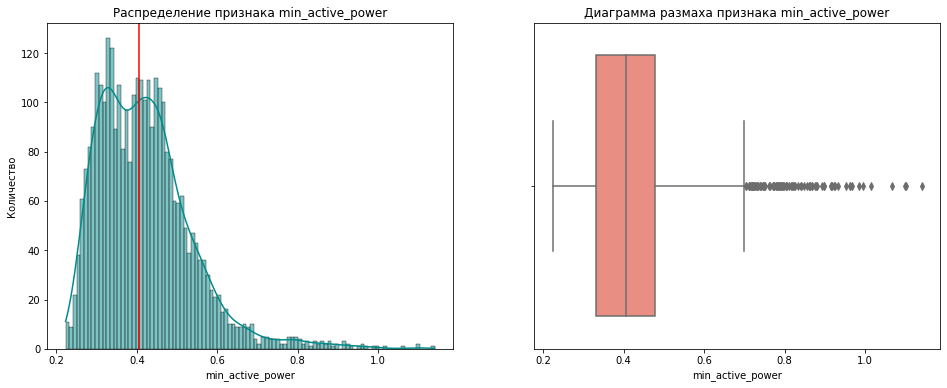

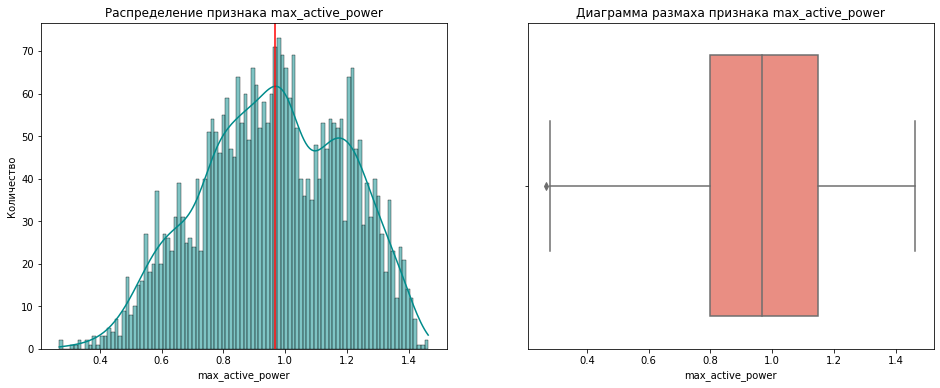

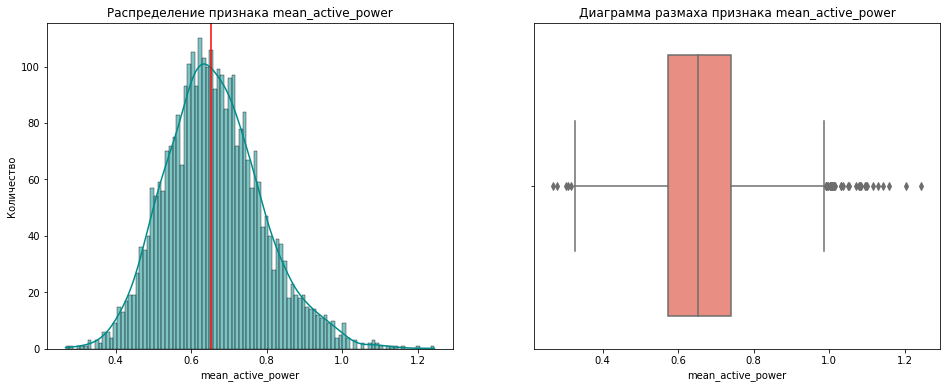

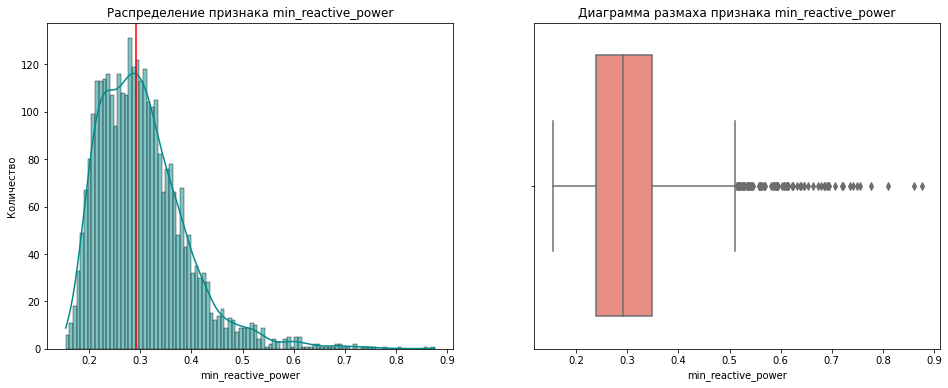

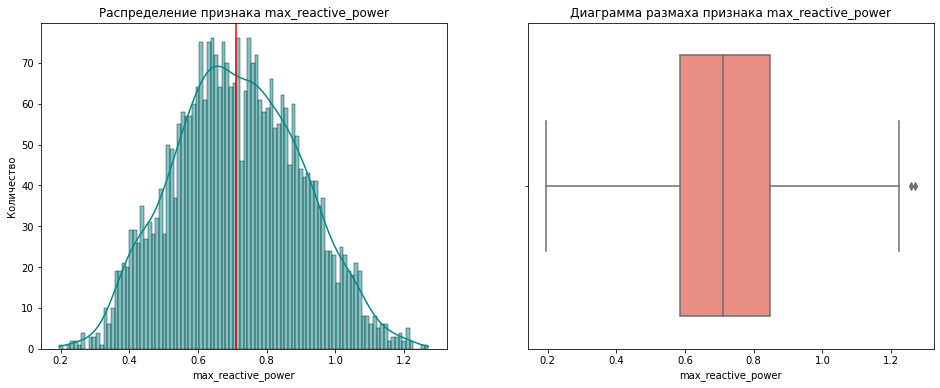

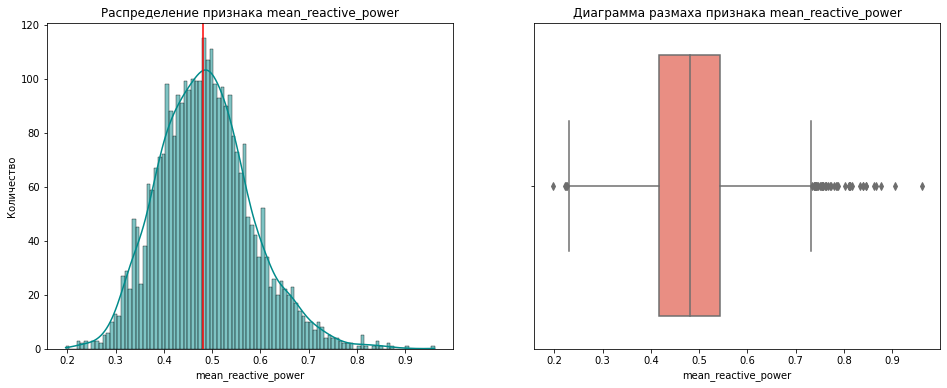

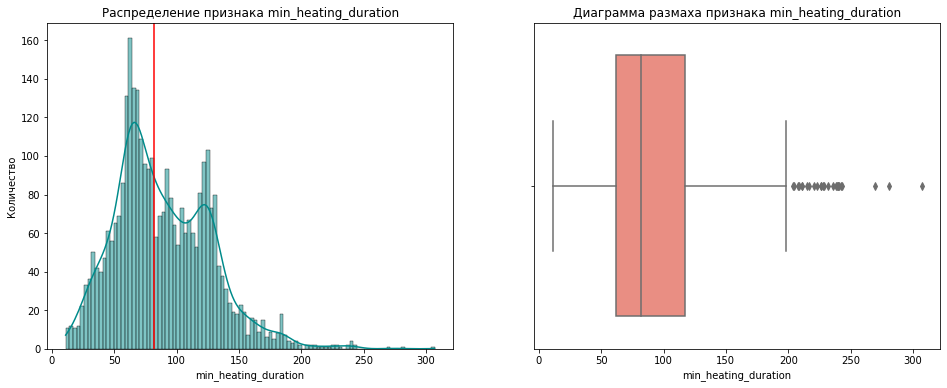

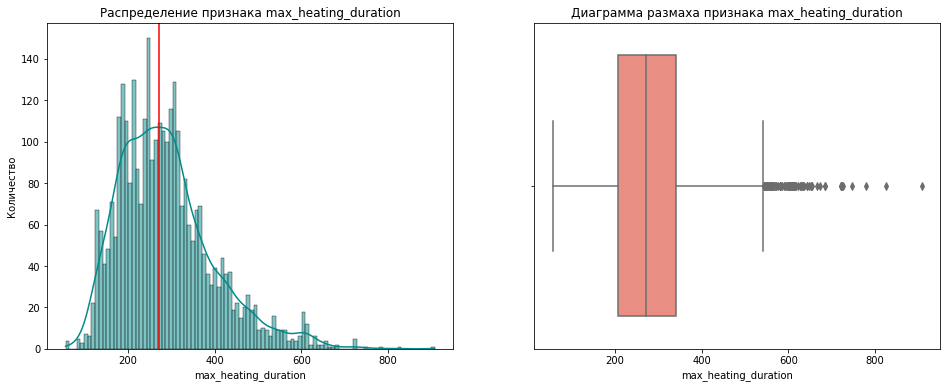

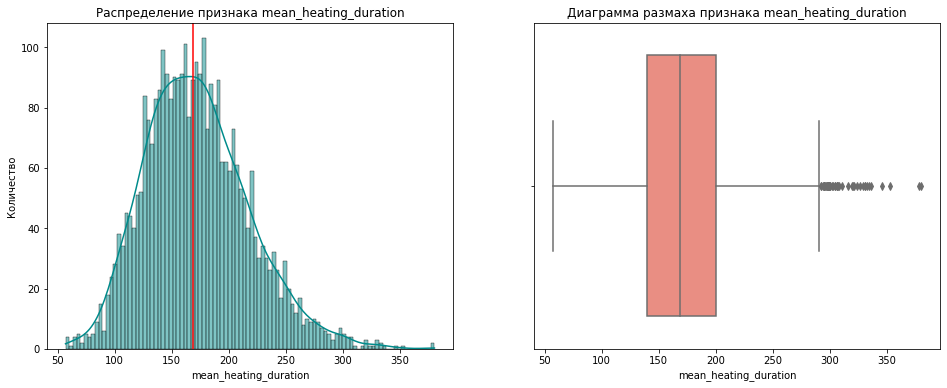

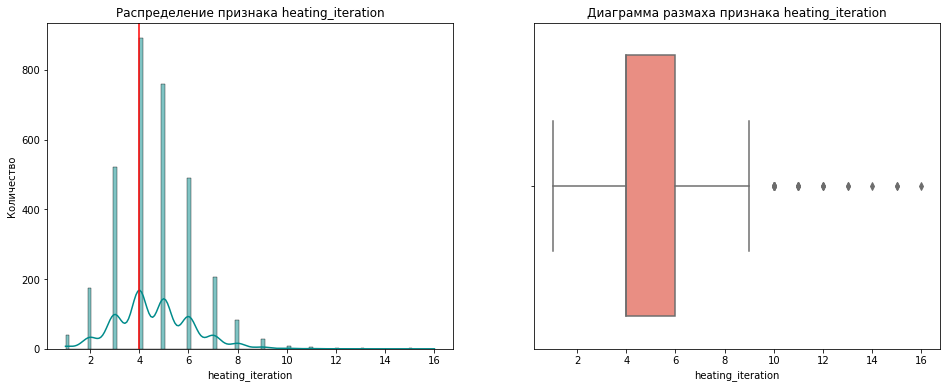

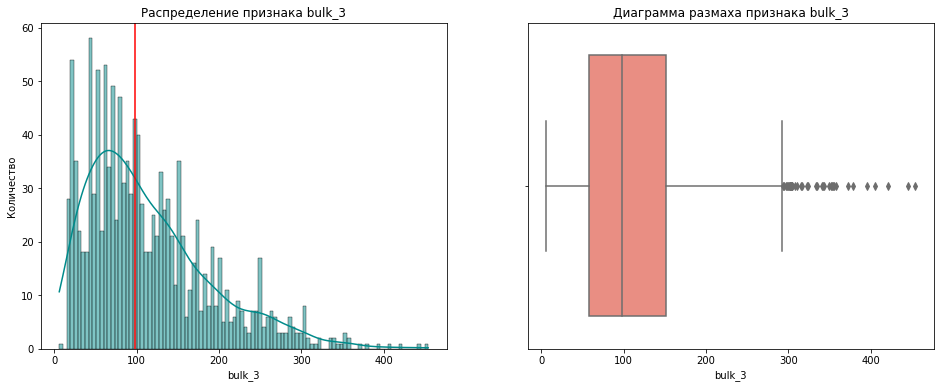

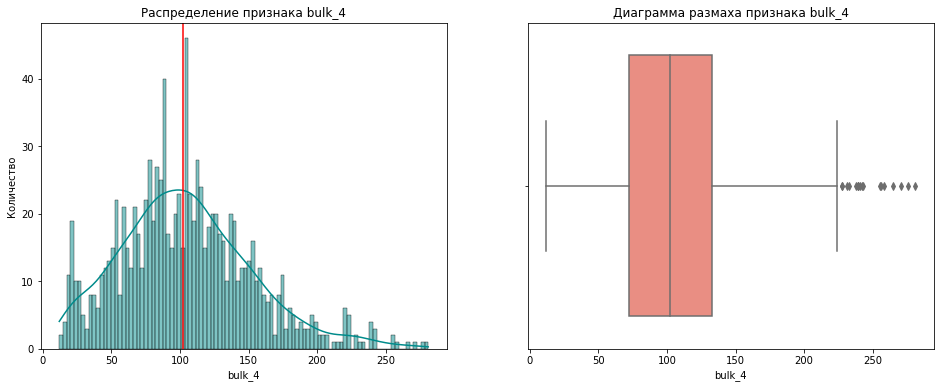

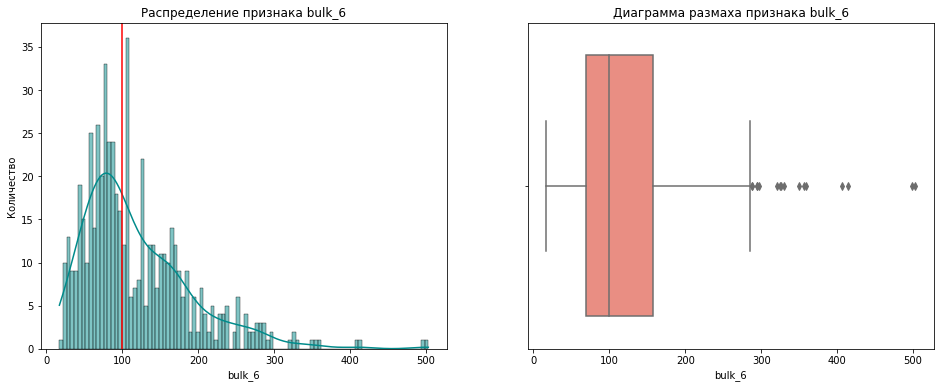

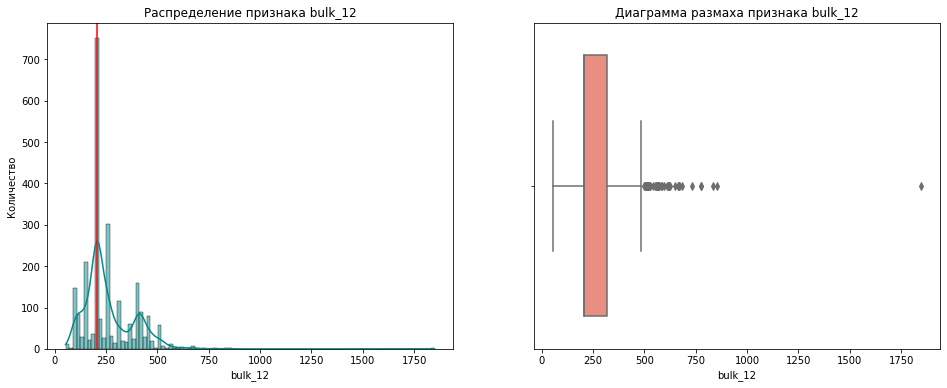

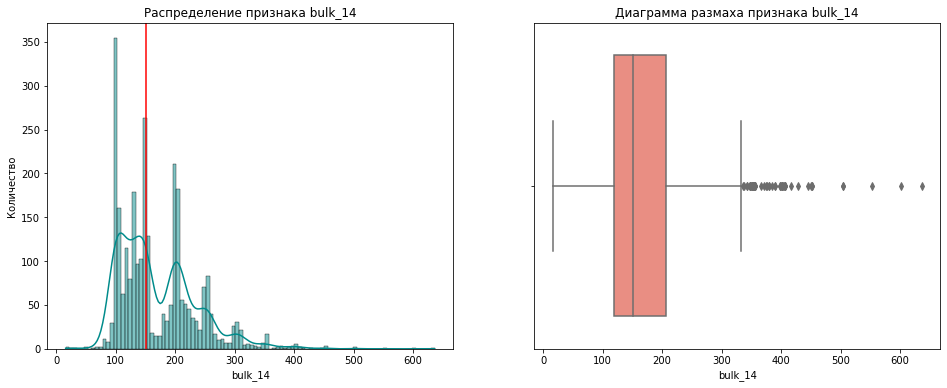

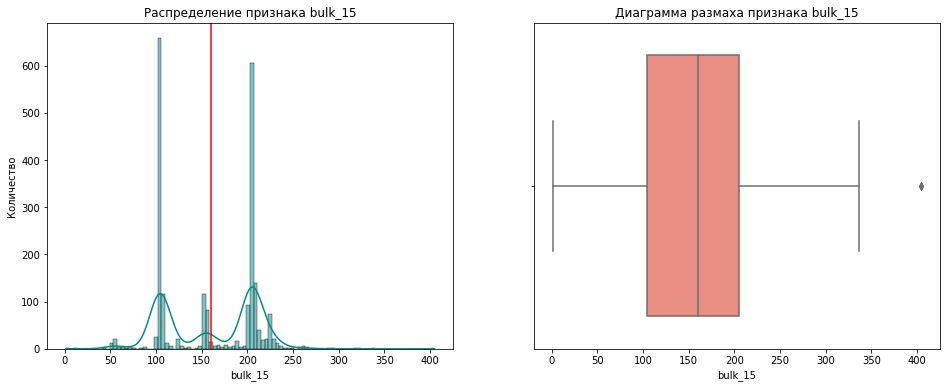

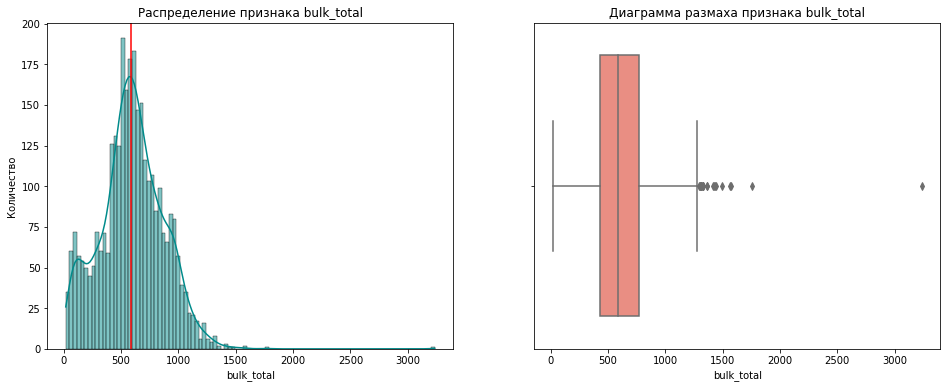

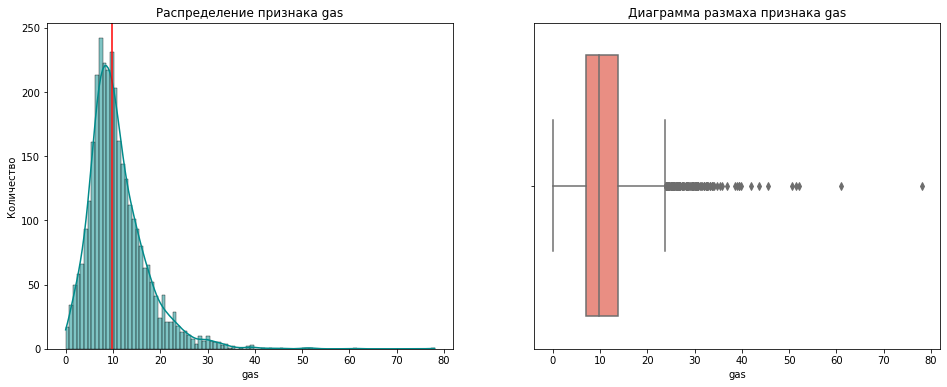

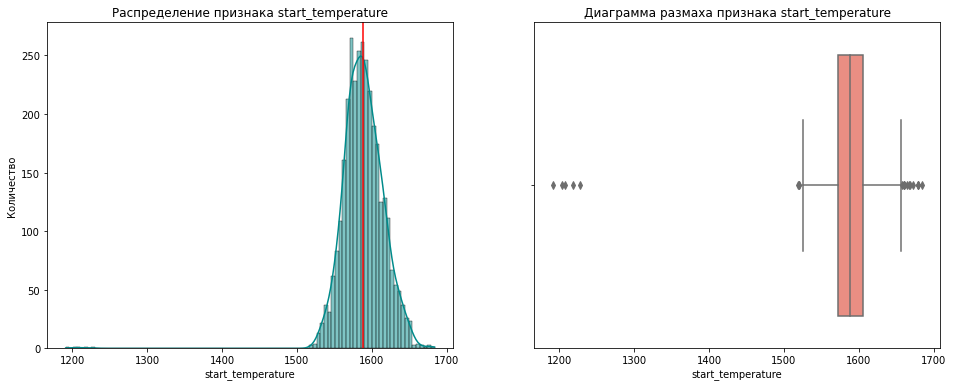

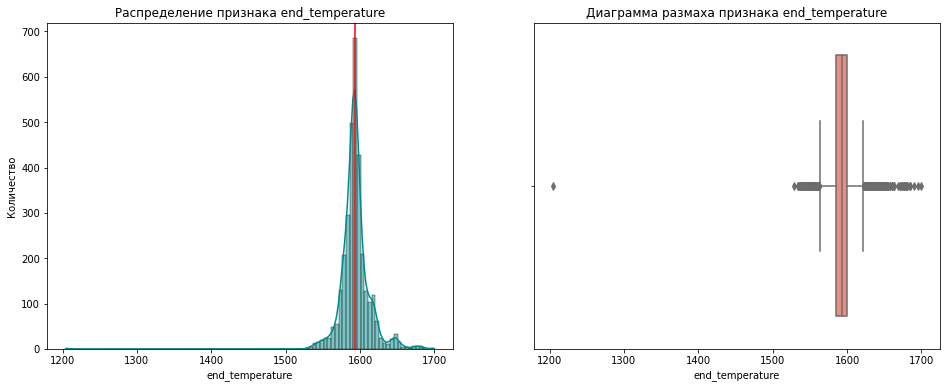

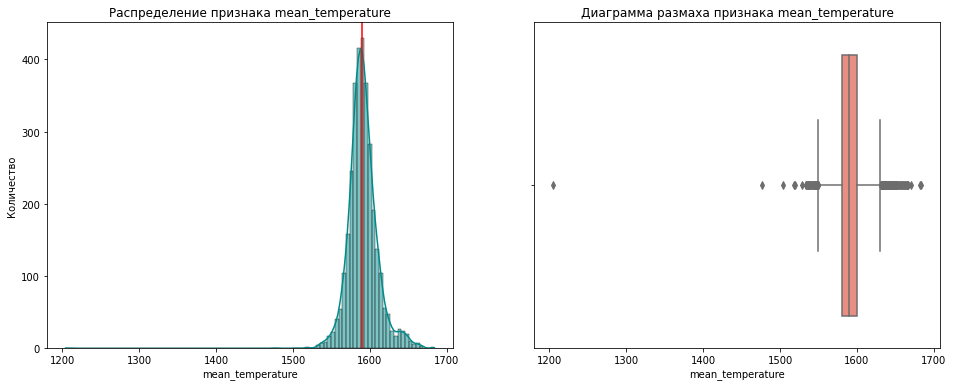

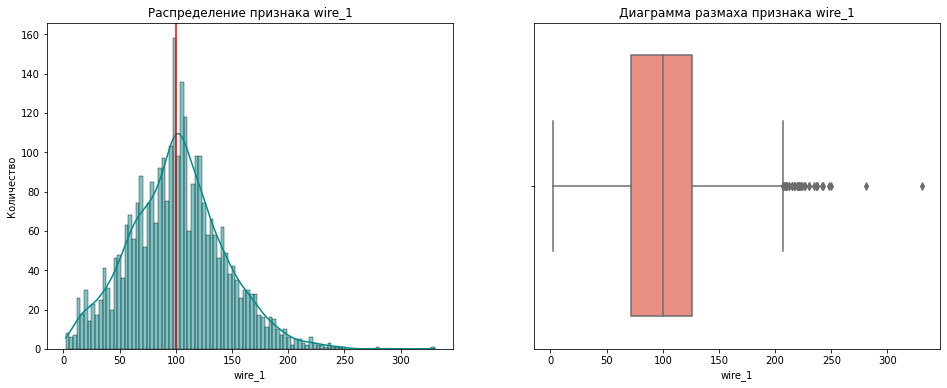

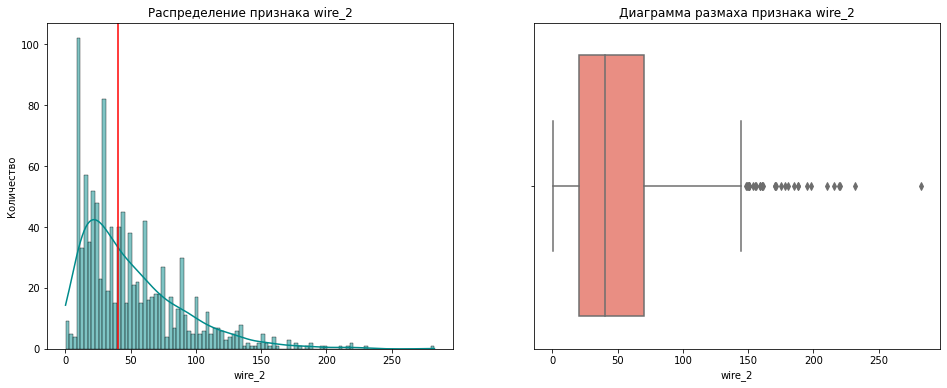

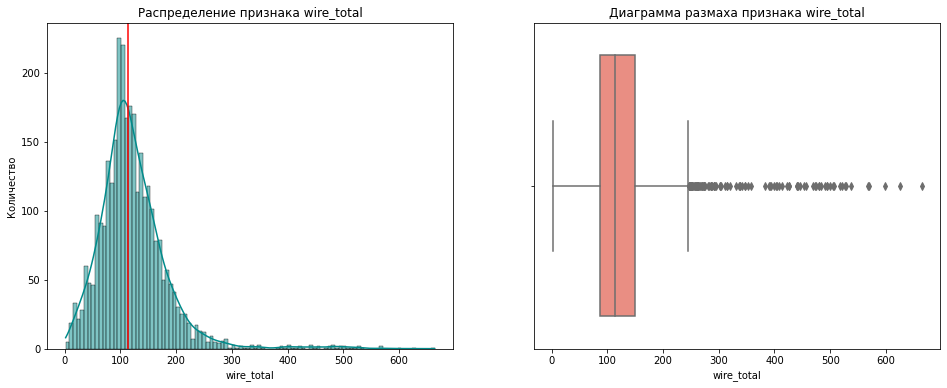

In [89]:
for i in data.drop('key', axis=1).columns:
    show_graph(
        data,
        i,
        f'Распределение признака {i}',
        f'Диаграмма размаха признака {i}',
        i
    )

## Подготовка данных для обучения моделей

## Обучение моделей машинного обучения

## Анализ моделей

## Итоговые выводы